&nbsp; 
  
#  <center>The Umpire Model</center>
## <center>Can we use Statcast data to demonstrate tendencies of MLB umpires?</center>
##### <center>University of Colorado Boulder | Unsupervised Algorithms in Machine Learning - Final Project</center>
##### <center>Jeremy Hurley | February, 2025</center>

&nbsp;  

---  

&nbsp;  

# Introduction:  
In Major League Baseball (MLB), determining balls and strikes is one of the most fundamental, yet important parts of the game. For those that aren't familiar with the rules of baseball, a pitch is called a strike if it crosses home plate within a designated strike zone. MLB defines the strike zone as:  
  
> the area over home plate from the midpoint between a batter's shoulders and the top of the uniform pants -- when the batter is in his stance and prepared to swing at a pitched ball -- and a point just below the kneecap.

One of the longstanding issues in baseball is that balls and strikes are subject to human error and interpretation. Pitches, some of which can reach 105 MPH, while moving both vertically and laterally, are called by human umpires who are standing behind the catcher. Generally, MLB umpires do an amazing job calling pitches, but they do miss one every now and then and, depending on the situation, the consequences can be substantial.  
  
One question we can ask is 'Do certain umpires tend to miss calls in one direction or the other?'. An umpire that tends to miss actual stikes (and calls them balls) would have a smaller strike zone and therefore be friendlier to hitters. Whereas an umpire that misses actual balls (and calls them strikes) would be friendlier to pitchers. The goal of this project is to cluster individual umpires according to their tendencies.   
  
The data for this project was generated by Statcast, which is an advanced tracking system introduced by the MLB in 2015. Statcast uses radar and optical cameras to record metric information on every play of every game in the MLB, including ball velocity, spin rates, launch angles and player movements.  

  
&nbsp;  

---  

&nbsp;  
  

# Data:  
The data for this project was pulled from the pybaseball Python package.    
  
The pybaseball Python package was developed by James LeDoux. It pulls data from multiple data sources, including FanGraphs, Baseball Reference and Baseball Savant. It contains a vast amount of data from every MLB game played in the modern era. For more information on pybaseball, find it's GitHub repo [here](https://github.com/jldbc/pybaseball)  
  
The umpire column in the Statcast data was not populated (possibly depricated), so I was able to find home plate umpire for each game in the 2023 season [here](https://umpscorecards.com/games/)  
  
Steps and descriptions of data acquisition, cleaning and saving can be found in the supplemental data notebook titled *'The Umpire Model - Data'*.  
  
This project starts by importing the dataset prepared and saved in the supplemental data notebook. Each row of the dataset represents one pitch in the 2023 MLB baseball season. Further, the dataset has been filtered to include only pitches that resulted in a ball or a called strike. Please reference the supplemental data notebook for the logic and process for creating the dataset.

In [1]:
import pandas as pd

# Load CSV file prepared in previous notebook
data = pd.read_csv('2023_strike_ball_data_with_umpires.csv')
data = data.dropna(subset=['release_speed'])

# Verify import
data.head()

,home_team,away_team,game_date,player_name,batter,pitcher,plate_x,plate_z,pitch_type,zone,...,pfx_x,pfx_z,plate_x.1,plate_z.1,on_3b,on_2b,on_1b,outs_when_up,pitch_name,umpire
0,NYM,PHI,2023-09-30,"Smith, Drew",664761,622098,1.24,1.57,SL,14,...,0.48,-0.11,1.24,1.57,NaN,NaN,NaN,2,Slider,Quinn Wolcott
1,NYM,PHI,2023-09-30,"Smith, Drew",656941,622098,0.76,0.78,CH,14,...,-1.37,0.82,0.76,0.78,NaN,NaN,NaN,0,Changeup,Quinn Wolcott
2,NYM,PHI,2023-09-30,"Smith, Drew",656941,622098,-1.29,4.77,CU,11,...,1.26,-0.65,-1.29,4.77,NaN,NaN,NaN,0,Curveball,Quinn Wolcott
3,NYM,PHI,2023-09-30,"Sánchez, Cristopher",677595,650911,0.37,0.20,CH,14,...,1.51,0.11,0.37,0.20,NaN,NaN,NaN,1,Changeup,Quinn Wolcott
4,NYM,PHI,2023-09-30,"Sánchez, Cristopher",677595,650911,-1.06,2.70,SI,13,...,1.55,0.06,-1.06,2.70,NaN,NaN,NaN,1,Sinker,Quinn Wolcott


In [2]:
# Get column and row count information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350478 entries, 0 to 350478
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   home_team      350478 non-null  object 
 1   away_team      350478 non-null  object 
 2   game_date      350478 non-null  object 
 3   player_name    350478 non-null  object 
 4   batter         350478 non-null  int64  
 5   pitcher        350478 non-null  int64  
 6   plate_x        350478 non-null  float64
 7   plate_z        350478 non-null  float64
 8   pitch_type     350478 non-null  object 
 9   zone           350478 non-null  int64  
 10  sz_top         350478 non-null  float64
 11  sz_bot         350478 non-null  float64
 12  type           350478 non-null  int64  
 13  release_speed  350478 non-null  float64
 14  release_pos_x  350478 non-null  float64
 15  release_pos_z  350478 non-null  float64
 16  release_pos_y  350478 non-null  float64
 17  description    350478 non-null  ob

# Exploratory Data Analysis:
Exploratory data analysis for this project will start by examining the balance between balls and strikes and a visualization of pitch locations.  
  
  

Percent of strikes: 0.33


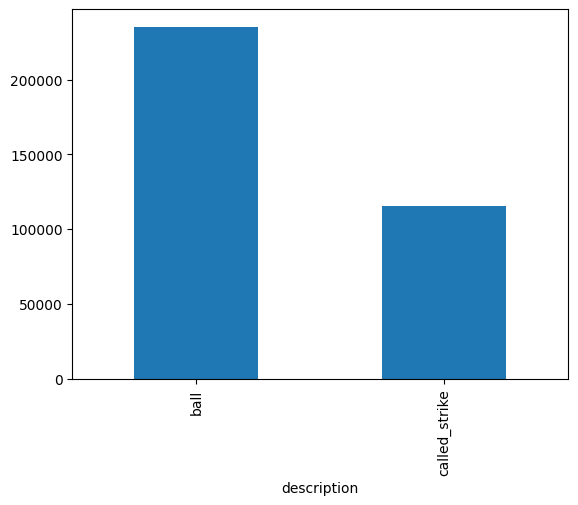

In [3]:
# Check for balance between balls and strikes.
data['description'].value_counts().plot(kind='bar')

# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {data['type'].mean():.2}')

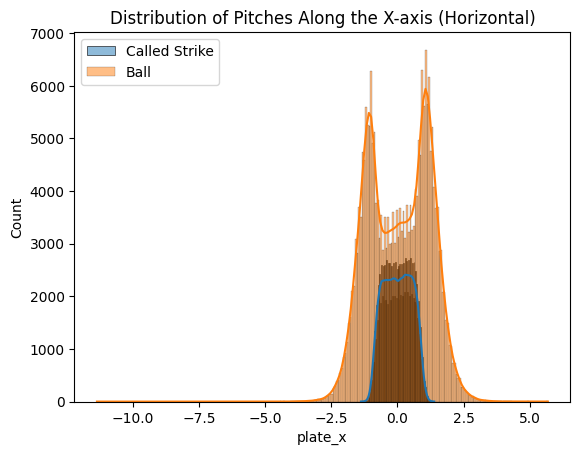

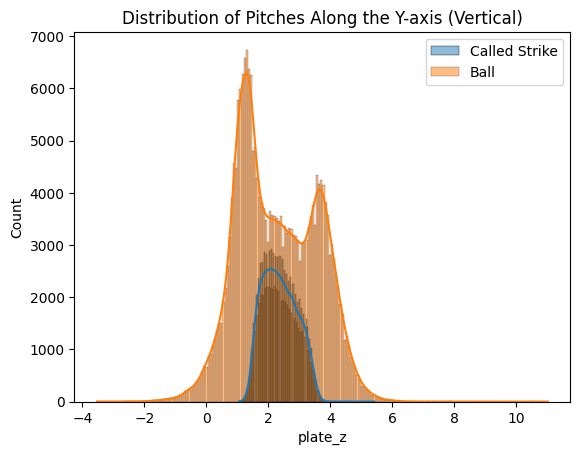

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data[data['type'] == 1]['plate_x'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_x'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the X-axis (Horizontal)')
plt.show()

sns.histplot(data[data['type'] == 1]['plate_z'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_z'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the Y-axis (Vertical)')
plt.show()

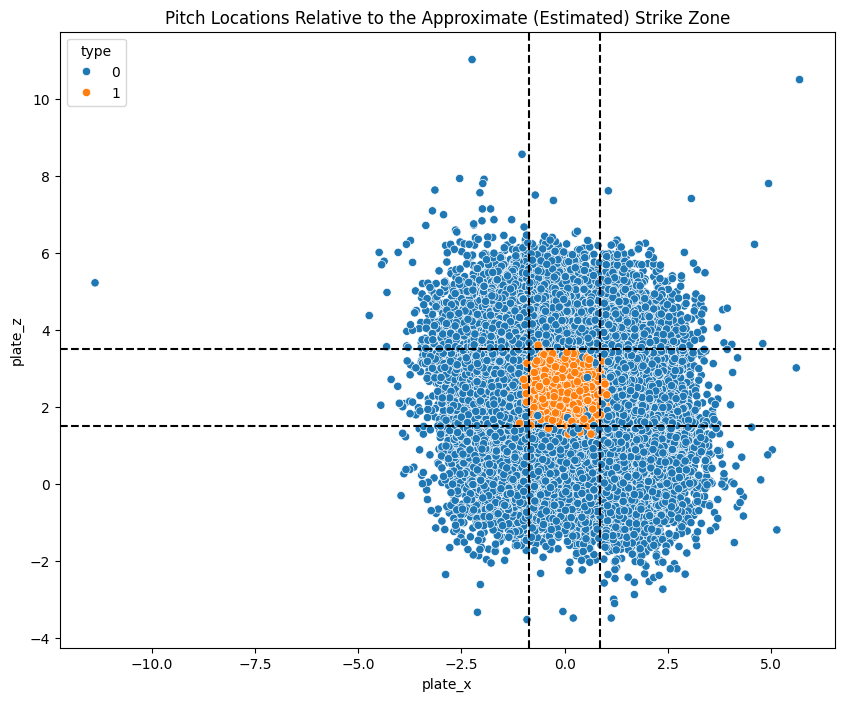

In [5]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='type', data=data)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.show()

## Exploratory Data Analysis - Preliminary Results:  
I learned two important insights about the data as a result of the EDA.  

- Balls outweigh strikes by about 2:1.
- There is a lot of noise outside what might reasonably be called a strike by an umpire.

Considering what we've learned, I will further filter the data based on vertical (plate_z) and horizontal (plate_x) position as such:  

- Remove rows where plate_z > 4.17 or < 0.83
- Remove rows where plate_x > 1.5 or < -1.5

Filtering this data removes points that would be about 8 inches or more outside the estimated strike zone. Now that Angel Hernandez is retired :), such pitches would have little chance of being called a stike and removing them will help balance the dataset and ensure the model can focus on the borerline pitches.

In [6]:
focused_data = data[
    (data['plate_x'] >= -1.5) & 
    (data['plate_x'] <= 1.5) & 
    (data['plate_z'] >= 0.83) & 
    (data['plate_z'] <= 4.17)
]

# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {focused_data['type'].mean():.2}')
print(f'Shape of new dataset: {focused_data.shape}')

Percent of strikes: 0.42
Shape of new dataset: (274203, 32)


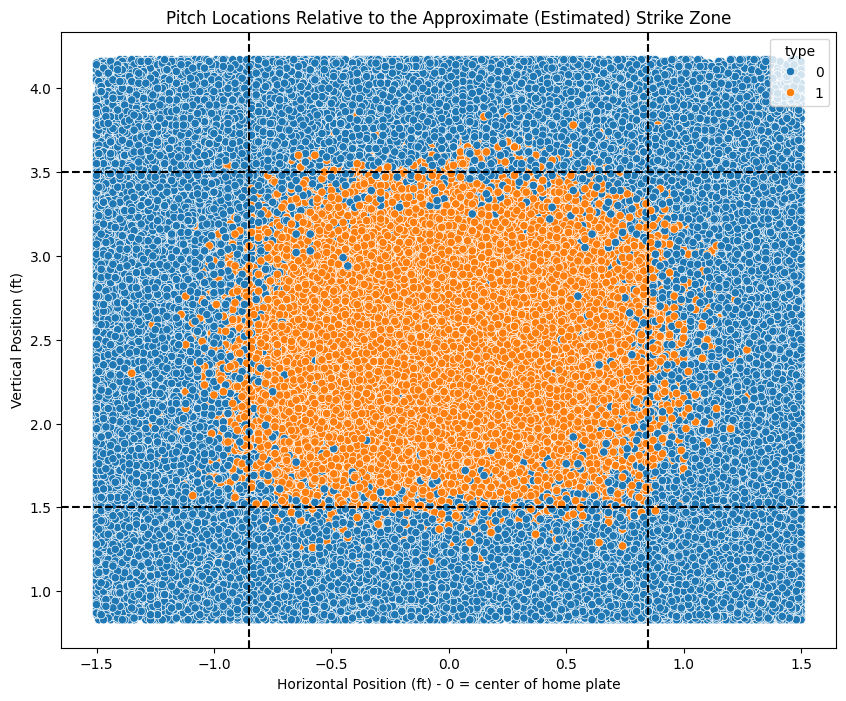

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='type', data=focused_data)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.gca().set(xlabel='Horizontal Position (ft) - 0 = center of home plate', ylabel='Vertical Position (ft)')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.show()

## Exploratory Data Analysis - Final Results and Conclusions:  
Exploratory data analysis was used to remove noise and add balance to the dataset.  

The dataset now contains pitch data that is either in the strike zone or within 8 inches of the expected strike zone. This should improve the model by removing noisy data and improved the balance of strike to balls from 0.33 to 0.42.

**Note:** A correlation matrix was run but not shown because there was little meaningful data or results. There was a very slight positive correlation (0.15) between release_speed and plate_z, which suggests that velocities slightly increase for pitches higher in the strike zone. This has no bearing on this project, but I found it interesting as someone who's been around baseball for most of my life, as most hitters talk about trying to lay off (not swing at) high fastballs because they look enticing, but are hard to catch up to. Maybe there is some truth to that.  
&nbsp;  

---  

&nbsp;  
  

## Feature Engineering - Classifying actual strikes, balls and missed calls:  
I'm going to further process the data by adding columns that categorize pitches based on the actual definition of the strike zone and whether an umpire called an actual strike a ball or an actual ball a strike.  

**Note:** I will use +/- 0.83 as the horizontal width of the strike zone. This accounts for the size of home plate and the width of the baseball. Further, I will use sz_bot and sz_top as the actual top and bottom of the strike zone as measured by statcast.

In [20]:
import numpy as np

# Classify each pitch as an actual strike or ball
def is_in_strike_zone(row):
    return (-0.83 <= row['plate_x'] <= 0.83) and (row['sz_bot'] <= row['plate_z'] <= row['sz_top'])

# Apply function and create new column for actual strike classification
data['actual_strike_zone'] = data.apply(is_in_strike_zone, axis=1)

# Convert boolean to integer
data['actual_strike_zone'] = data['actual_strike_zone'].astype(int)

# Add column for called strike
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)


In [21]:
# Check distribution
print(data['actual_strike_zone'].value_counts())

# Check classifications
print(data[['actual_strike_zone', 'plate_x', 'plate_z', 'sz_bot', 'sz_top', 'description','called_strike']].head(10))

actual_strike_zone
0    248613
1    101865
Name: count, dtype: int64
   actual_strike_zone  plate_x  plate_z  sz_bot  sz_top    description  \
0                   0     1.24     1.57    1.64    3.59           ball   
1                   0     0.76     0.78    1.59    3.34           ball   
2                   0    -1.29     4.77    1.55    3.37           ball   
3                   0     0.37     0.20    1.84    3.82           ball   
4                   0    -1.06     2.70    1.90    3.93           ball   
5                   0     0.88     1.47    1.64    3.46           ball   
6                   0     1.13     3.23    1.64    3.40           ball   
7                   1    -0.23     2.31    1.64    3.48  called_strike   
8                   1    -0.42     1.97    1.64    3.34  called_strike   
9                   0     0.95     0.78    1.67    3.48           ball   

   called_strike  
0              0  
1              0  
2              0  
3              0  
4              0  
5 

In [24]:
# Identify actual strikes that were called balls
data['actual_strike_called_ball'] = np.where(
    (data['actual_strike_zone'] == 1) & (data['called_strike'] == 0), 1, 0
)

# Identify actual balls that were called strikes
data['actual_ball_called_strike'] = np.where(
    (data['actual_strike_zone'] == 0) & (data['called_strike'] == 1), 1, 0
)

# Check distributions
print("Total actual strikes called as balls:", data['actual_strike_called_ball'].sum())
print("Total actual balls called as strikes:", data['actual_ball_called_strike'].sum())

Total actual strikes called as balls: 7810
Total actual balls called as strikes: 21307


---  
  
Interesting results, it looks like an umpire is almost 3 times as likely to call an actual ball (a ball that crossed home plate outside the strict definition of the strike zone) a strike than they are to call an actual strike a ball. This would suggest that the error usually favors that pitcher.  

Now let's try to use a clustering model to group umpires based on their tendencies.    

&nbsp;  

---  

&nbsp;  
  

# Models:  

Before running the model, I'm going to aggregate the data calculated previously based on umpire.


In [29]:
# Aggregate on umpire
umpire_stats = data.groupby('umpire').agg(
    total_pitches = ('called_strike', 'count'),
    total_called_strikes = ('called_strike', 'sum'),
    total_actual_strike_called_ball = ('actual_strike_called_ball', 'sum'),
    total_actual_ball_called_strike = ('actual_ball_called_strike', 'sum')
).reset_index()

# Compute error rates
umpire_stats['strike_miss_rate'] = umpire_stats['total_actual_strike_called_ball'] / umpire_stats['total_pitches']
umpire_stats['ball_miss_rate'] = umpire_stats['total_actual_ball_called_strike'] / umpire_stats['total_pitches']
umpire_stats['strike_tendency'] = umpire_stats['total_called_strikes'] / umpire_stats['total_pitches']

# Select features for clustering
clustering_features = umpire_stats[['strike_miss_rate', 'ball_miss_rate', 'strike_tendency']]

umpire_stats.head()

,umpire,total_pitches,total_called_strikes,total_actual_strike_called_ball,total_actual_ball_called_strike,strike_miss_rate,ball_miss_rate,strike_tendency
0,Adam Beck,4057,1329,64,247,0.015775,0.060882,0.327582
1,Adam Hamari,4063,1313,98,237,0.024120,0.058331,0.323160
2,Adrian Johnson,4208,1279,156,167,0.037072,0.039686,0.303945
3,Alan Porter,4459,1473,70,257,0.015699,0.057636,0.330343
4,Alex MacKay,2446,821,54,155,0.022077,0.063369,0.335650


### K-Means clustering

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
umpire_stats['cluster'] = kmeans.fit_predict(clustering_scaled)

# Show the clusters
print(umpire_stats[['umpire', 'strike_miss_rate', 'ball_miss_rate', 'strike_tendency', 'cluster']].head(20))

             umpire  strike_miss_rate  ball_miss_rate  strike_tendency  \
0         Adam Beck          0.015775        0.060882         0.327582   
1       Adam Hamari          0.024120        0.058331         0.323160   
2    Adrian Johnson          0.037072        0.039686         0.303945   
3       Alan Porter          0.015699        0.057636         0.330343   
4       Alex MacKay          0.022077        0.063369         0.335650   
5         Alex Tosi          0.018660        0.054575         0.326043   
6   Alfonso Marquez          0.026173        0.057310         0.322202   
7     Andy Fletcher          0.023961        0.068490         0.339271   
8   Angel Hernandez          0.026139        0.065684         0.327078   
9           Ben May          0.018145        0.055795         0.338852   
10      Bill Miller          0.010290        0.078578         0.358279   
11   Brennan Miller          0.026969        0.056634         0.328209   
12     Brian Knight          0.023410 

In [33]:
# Analyze the clusters
numeric_columns = umpire_stats.select_dtypes(include=['number']).columns

umpire_cluster_means = umpire_stats.groupby('cluster')[numeric_columns].mean()
print(umpire_cluster_means)

         total_pitches  total_called_strikes  total_actual_strike_called_ball  \
cluster                                                                         
0          4028.046875           1328.406250                        88.484375   
1          3210.923077           1113.230769                        53.461538   
2          2996.529412            933.647059                        85.411765   

         total_actual_ball_called_strike  strike_miss_rate  ball_miss_rate  \
cluster                                                                      
0                             247.343750          0.022007        0.061424   
1                             240.000000          0.017458        0.073411   
2                             138.647059          0.030027        0.046939   

         strike_tendency  cluster  
cluster                            
0               0.329880      0.0  
1               0.356496      1.0  
2               0.311652      2.0  


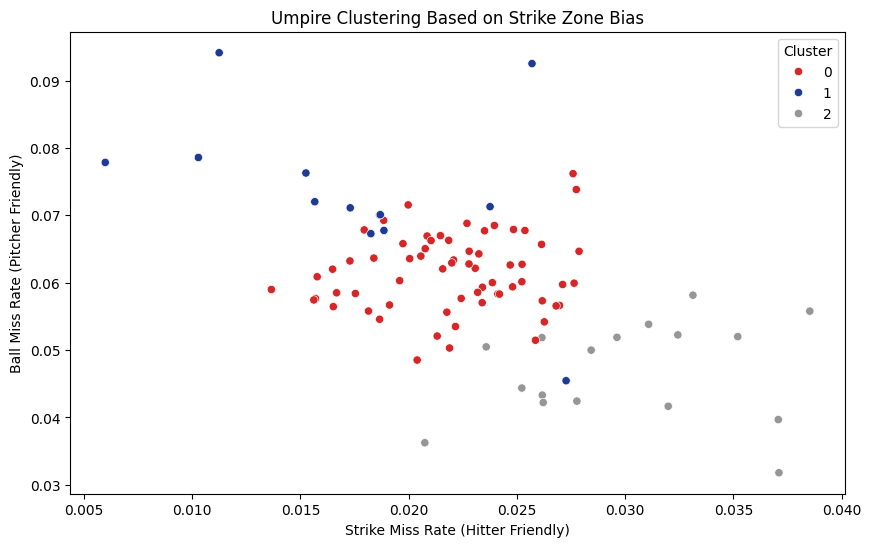

In [53]:
# Visualize the Results

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,6))
sns.scatterplot(
    x = umpire_stats['strike_miss_rate'],
    y = umpire_stats['ball_miss_rate'],
    hue = umpire_stats['cluster'],
    palette = ["#D62728", "#1F3A93", "#969696"]
)
plt.xlabel("Strike Miss Rate (Hitter Friendly)")
plt.ylabel("Ball Miss Rate (Pitcher Friendly)")
plt.title("Umpire Clustering Based on Strike Zone Bias")
plt.legend(title = "Cluster")
plt.show()

## Results Interpretation  

The results show a clear gradient in the tendencies of MLB umpires with respect to whether they tend to err on the side of calling an actual ball a strike, or vice-versa.  

Given that we removed many instances of balls that were significantly outside the strike zone, the actual rates (strike miss rate vs. ball miss rate) can not be compared directly, but this allows for the comparison across umpires.  
  
The K-Means clustering performed well. There are 3 clusters that you could use to categorize an umpire as hitter friendly (high strike miss rate and low ball miss rate), pitcher friendly (high ball miss rate and low strike miss rate) or balanced (middle of the pack for each).

# Discussion and Conclusion: 

### Did this project accomplish it's goal?  

I'm actually quite happy with the results of this project. I set out to see if I could demonstrate the tendencies of individual umpires for calling balls and strikes and use a clustering model to group them according to who they might favor (hitters, pitchers or balanced). In my opinion, I was successful in this goal, the final graph does a nice job of showing these clusters.  

### What I learned in the project  

This was a great learning experience for me. I was able to build off of a prior project from the supervised modeling course. As part of the data collection, I had to find a source for the home plate umpire for each game and merge that with the pybaseball data. In addition to that, I was able to further build python knowledge and experience.  

### Future works and ways to build off this project

There are actually quite a few ways to further analyze this data. It would be interesting to group by pitchers or hitters to see there were any biases for or against individuals when calling balls and strikes.

### Parting Words
I hope you enjoyed reading this project as much as I enjoyed creating it. I'm facscinated by the application of data science to the sport that I love and will continue to use baseball as the foundation of future projects. Thanks for reading!!